# Implementing Iris Classification using a QUBO model with D-Wave’s ocean sdk
## Name: David Jesús Árbol Guerrero
## Research Project - Quandela - Quarmen Erasmus Mundus Joint Master

# Introduction

In this project we treat the problem of optimal clusterisation of a dataset for a further training of a machine learning model. Here, we focus in the first step, the problem of clusterisation, which can be regarded as a QUBO problem. The objective of this work is to replicate the QUBO problem defined in [1] in D-Wave, to solve it using Simulated Quantum Annealing and Quantum Annealing, possibly adding new constraints; and finally to discuss the dependence of the problem's complexity with the size of the dataset.

Concretely, we will use the Iris Dataset.

In [1]:
#First if not yet done, install the ocean sdk package 
#!pip install dwave-ocean-sdk
#!pip install networkx
#!pip install inspector


You need to https://www.dwavesys.com/build/getting-started/ and connect to your leap account with the following commands run in a terminal (and follow instructions)

```
dwave auth login --oob
dwave auth get
dwave config create --auto-token
```

And the following to be able to use dwave inspector (read the EULA):

```
dwave install inspector
```

# Iris Dataset

The Iris Dataset is a classically used dataset which contains information about sepals length and width, and petals length and width in cm of many samples within 3 different species of flowers: 'setosa', 'versicolor' and 'virginica'. 

For simplicity we will enumerate these species as 0, 1 and 2 respectively.

Therefore, as explained in [1] we must separate the dataset $X$ in different pure-class subsets: $X^0, X^1,...,X^v \subset X$; and in this case $v=2$ to have 3 subsets.

In [1]:
# Importar bibliotecas
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances
import copy

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

from dwave.system import LeapHybridSampler
import dwave.inspector

We will use a part of our dataset. Thus, we will be able to analyse the different results given for different sizes of dataset. We select this with ```train_size```= 0.5 if we are using the $50\%$ of the data.

In [2]:
# Cargar conjunto de datos de IRIS
iris = load_iris()
X, y = iris.data, iris.target

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True) #shuffle must be True because data is ordered with y=0,1,2

# Formular el problema de clasificación como un problema QUBO
# (Código para la formulación QUBO se omite por brevedad)

```n[k]``` = Number of elements in each class. We will represent it as $N$.

In [3]:
n=np.array([0,0,0])
for i in range(3):
    n[i]=np.sum(y_train==i)


```G[k]``` = Pure-class subset of class ```k```. We will represent is as $X^k$

In [4]:
G=[0,0,0]
for i in range(3):
    G[i]=X_train[np.where(y_train==i)]

# Finding the best K number of clusters for each subset

As said in [1] we use  ```from sklearn.cluster import KMeans ``` and ```from sklearn.metrics import silhouette_score ``` to guess which is the best number of clusters for each subset.

In [5]:
def find_optimal_k(subset):
    silhouette_scores = []
    for k in range(2, len(subset)):  # We assume that the maximum number of clusters is the number of samples in the subset
        kmeans = KMeans(n_clusters=k)
        cluster_labels = kmeans.fit_predict(subset)
        silhouette_scores.append((k, silhouette_score(subset, cluster_labels)))
    optimal_k = max(silhouette_scores, key=lambda x: x[1])[0]
    return optimal_k

# Finding the optimal number of cluster for each subset
optimal_ks = {}
for i in range(3):
    optimal_ks[i] = find_optimal_k(G[i])

print("Optimal number of clusters for each subset:")
for i, k in optimal_ks.items():
    print(f"Subset {i}: K = {k}")

Optimal number of clusters for each subset:
Subset 0: K = 2
Subset 1: K = 2
Subset 2: K = 3


```K[k]``` = Optimal number of clusters in subset ```k```. We will represent it as $K$.

In [6]:
#K of each subset
K=optimal_ks

# Defining the QUBO Problem for clustering each subset

We can define a QUBO problem for each subset $X^r$ to generate the clustering. Let's consider the subset $X^r$, $r\in \{0,...,v\}$. To achieve a good cluster, an appropiate one for training a further machine learning model, we want it to have 3 properties: 

### -Minimum distances [1,2]: 



Given a cluster $\Phi_j\subset X^r$, each point in it must be as near as possible to all the other points in the same cluster. For this reason, we define our _objective function_, function whose minimisation will give us the optimal assigment of a cluster to each point. For that reason we use:

\begin{equation}
    \min\sum_{i=1}^{K}\sum_{x,y\in\Phi_i} ||x-y||^2
\end{equation}
with $x,y$, points the considered the subset, $\Phi_j\subset X^r$ cluster number $j$ and $K$ the optimal amount of clusters in this subset.

This can be regarded as a QUBO problem defining:

\begin{equation}
    \hat{w}= [ \underbrace{w_{0,0},... ,w_{N-1,0}}_\text{cluster 1}, \underbrace{w_{1,2}, ..., w_{N-1,2}}_\text{cluster 2}, ..., \underbrace{w_{1,K-1},...,w_{N-1,K-1}}_\text{cluster K-1} ] = [ w_{ij} ]. 
\end{equation}
with $i\in \{ 0, ... , N-1 \}$ running in all possible points and $j\in \{ 0, ... , K-1 \}$ running in all possible clusters.

$\hat{w}$ is defined as:
\begin{equation*}
    w_{ij}=
    \begin{cases}
        1 & \text{if $x_i\in \Phi_j$ } \\
        0 & \text{if $x_i\notin \Phi_j$}
    \end{cases}
\end{equation*}

Then, the _objective function_ is:
\begin{equation}
    f(\hat{w})=\hat{w}^T(I_k \otimes D)\hat{w}
\end{equation}
with $I_K$, the identity matrix of order $K$ and $D$ the matrix of squared distances among points in this subset.

### - Penalty 1 [1,2]:

We want to add the constraint that each piece of data must belong to exactly one cluster. Otherise, the minimisation would be trivial: $\hat{w}= [ 0,...,0 ]$, which would make no sense.

To achieve this, we add a term in the objective function, that is minimum when each point is assigned to exactly one cluster and multiplied by a factor $\beta$. This factor must be large enough to obtain solutions that fulfil the constraint but not too much, so we do not loose the main objective: minimising distances within each cluster. From [2] we know that the best option is $\beta=max(D)$.

The penalty is defined as:
\begin{equation}
    P_1(\hat{w})= \beta\sum_{i=0}^{N-1}(\hat{w}_i^T\hat{w}_i-1)^2
\end{equation}
with $\hat{w}_i= [ w_{i,0},...,w_{i,K-1} ]$.

We must find its expression in the formalism we are considering. Matrix calculus can require many resources when the problem size increases so instead of this complex way as $P_1$ was defined in [2], I calculate its shape differently:

\begin{equation}
    \beta(\hat{w}_i^T\hat{w}_i-1)^2=\beta(\sum_j w_{ij}^2-1)^2=-\beta\sum_j w_{ij}^2 + \beta \sum_{j\neq j'} w_{ij}\,w_{ij'}+\beta
\end{equation}

We can neglect the last term because it is a constant, which has no use in an optimisation problem. Moreover, we get that the diagonal terms are $-\beta$ and the non-diagonal terms are $0$ if $i\neq i'$ and $+\beta$ if $i= i'$, $j \neq j'$.

### - Penalty 2 [2]: 

Secondly, we want to add a constraint for the clusters to be balanced. This means that clusters within a same subset have a similar size. **This is something that was not considered or explained in [1]** but I found in [2] a way to define this.

The penalty is defined as:
\begin{equation}
    P_2(\hat{w})= \alpha\sum_{j=0}^{K-1}({\hat{w}'}_j^T{\hat{w}'}_j-N/K)^2
\end{equation}
with ${\hat{w}'}_j= [ w_{0,j},...,w_{N-1,j} ]$.

Similarly as with $P_1$, matrix multiplications can require many resources, so I calculate its shape in a different way from [2]:

\begin{equation}
    \alpha({\hat{w}'}_j^T{\hat{w}'}_j-\frac{N}{K})^2=\alpha(1-\frac{2N}{K})\sum_i w_{ij}^2 + \alpha \sum_{i\neq i'} w_{ij}\,w_{i'j}+const.
\end{equation}


The diagonal terms are $\alpha(1-\frac{2N}{K})$ while the non-diagonal terms are $0$ if $j\neq j'$ and $+\alpha$ if $j= j'$, $i \neq i'$.

# Implementation of the presented theoretical problem

## Definition of each distance matrix for each subset

In [7]:
from scipy.linalg import block_diag
D=[np.zeros((n[0],n[0])),np.zeros((n[1],n[1])),np.zeros((n[2],n[2]))]
D_qubo=[np.zeros((n[0]*K[0],n[0]*K[0])),np.zeros((n[1]*K[1],n[1]*K[1])),np.zeros((n[2]*K[2],n[2]*K[2]))]

for k in range(3):
    D[k]=euclidean_distances(G[k])**2
    blocks=[D[k]]*K[k]
    D_qubo[k]=block_diag(*blocks)

## Definition of penalty 1

In [8]:
beta=[np.max(D[0]), np.max(D[1]), np.max(D[2])]

In [9]:
P1=[np.zeros((n[0]*K[0],n[0]*K[0])),np.zeros((n[1]*K[1],n[1]*K[1])),np.zeros((n[2]*K[2],n[2]*K[2]))]
for k in range(3):
    np.fill_diagonal(P1[k],-beta[k])
    for i in range(n[k]):
        for j in range(K[k]):
            for l in range(K[k]):
                if l!=j:
                    P1[k][i+n[k]*j,i+n[k]*l]=beta[k]

## Definition of penalty 2

In [10]:
alpha=[0,0,0]
for k in range(3):
    alpha[k]=(beta[k]) / ( (2*n[k]/K[k]) -1)

In [11]:
P2=[np.zeros((n[0]*K[0],n[0]*K[0])),np.zeros((n[1]*K[1],n[1]*K[1])),np.zeros((n[2]*K[2],n[2]*K[2]))]
for k in range(3):
    np.fill_diagonal(P2[k], alpha[k]*(1-2*n[k]/K[k]) )
    for j in range(K[k]):
        for i in range(n[k]):
            for l in range(n[k]):
                if l!=i:
                    P2[k][i+n[k]*j,l+n[k]*j]=alpha[k]

## Complete QUBO matrix: sum of distances and penalties

We need a function that transforms a matrix to a dictionary to be able to use D-Wave libraries.

In [12]:
def QUBO_matrix_to_dictionary(qubo_matrix):
    qubo_dict = {}
    rows, cols = qubo_matrix.shape

    for i in range(rows):
        for j in range(cols):
            if qubo_matrix[i, j] != 0:  # Solo incluir elementos no nulos
                qubo_dict[(i, j)] = qubo_matrix[i, j]
    return qubo_dict

**Choose** to read the chunck depending on **whether you want to use the penalty 2 or not**.

In [13]:
#With penalty 1 and 2
QUBO_mat=copy.deepcopy(D_qubo)
QUBO_dict=[{},{},{}]
for k in range(3):
    QUBO_mat[k]=D_qubo[k]+P1[k]+P2[k]
    QUBO_dict[k]= QUBO_matrix_to_dictionary(QUBO_mat[k])

The heatmap of the QUBO matrices for each subset.

Symmetric : True


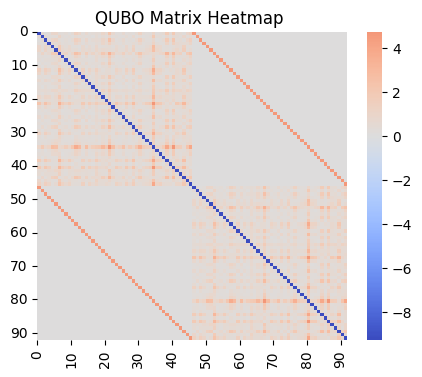

Symmetric : True


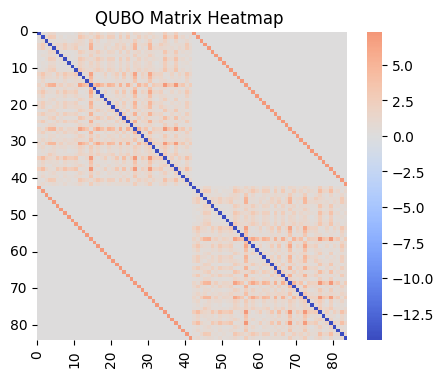

Symmetric : True


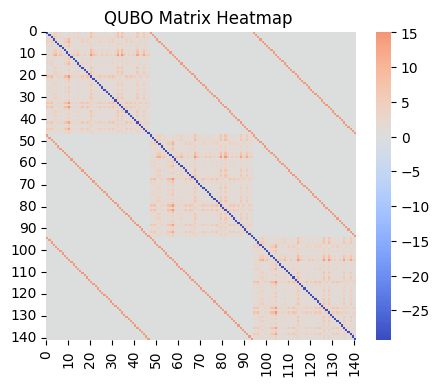

In [14]:
for l in range(len(QUBO_mat)):
    qubo_matrix = QUBO_mat[l]
    print('Symmetric :', np.allclose(qubo_matrix, qubo_matrix.T, rtol=1e-05, atol=1e-08))
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(qubo_matrix, cmap='coolwarm', center=0) # (qubo_matrix.max() + qubo_matrix.min())/2)
    plt.title('QUBO Matrix Heatmap ')
    ax.set_xticks(np.arange(0, qubo_matrix.shape[1], 10))
    ax.set_yticks(np.arange(0, qubo_matrix.shape[0], 10))
    ax.set_xticklabels(np.arange(0, qubo_matrix.shape[1], 10))
    ax.set_yticklabels(np.arange(0, qubo_matrix.shape[0], 10))
    plt.show()

# Classical solver

## Some functions needed to characterise the solution

```CheckClusters``` check if a solution fulfils the condition that each point is exactly in an only cluster. It returns:
- ```False```/```True```: Depending on if it fulfils the condition.
- ```check```[i]=j : Point $i$ is associated to a quantity $j$ of different clusters.
- ```ratio``` : Ratio of points that fulfil the condition.

In [15]:
# Check how many clusters a point is associated to

def CheckClusters(w,N,K):  
    assert len(w)==N*K, 'len(w) must equal N*K'
    check=np.array([0]*N)   # Vector that tells how many clusters a point is associated to. 
    for i in range(N*K):

        if w[i]==1:
            check[i%N]=check[i%N]+1

    if np.all(check==1):
        return True, check
    else:
        ratio=sum(check==1)/N
        return False, check, ratio

```AssignCluster``` : Returns a vector ```assignment[i]=j``` meaning that:
- $-2$: The point $i$ is multiply assigned.
- $-1$: The point $i$ is not assigned to any cluster.
- $j\neq -1,-2$: The point $i$ is asigned to the cluster number $j$.

In [16]:
def AssignCluster(w,N,K):
    assert len(w)==N*K, 'len(w) must equal N*K'
    assignment=np.array([-1]*N)   # assigment[i]=j : Point i is associated to cluster j. 
    for j in range(K):
        for i in range(N):
            if w[i+N*j]==1 and assignment[i]==-1:
                assignment[i]=j
            elif w[i+N*j]==1 and assignment[i]!=-1:
                assignment[i]=-2
    return assignment            # j=1,2,3...: Cluster nº j ; j=-1 Not assigned;  j=-2: Multiply assigned

## Solve by trying all possibilities

We define the Binary Quadratic Model from our QUBO problem.

In [17]:
from dimod import BinaryQuadraticModel
bqm=[0,0,0]
for k in range(3):
    bqm[k] = BinaryQuadraticModel.from_qubo(QUBO_dict[k])
    

We try to sample all the possibilities ($>20\%$) but we see that python does not support those many variables when the size of the dataset is too big. We need to use QPU!

In [18]:
from dimod.reference.samplers import ExactSolver
# Exact Solver - https://docs.ocean.dwavesys.com/en/stable/docs_dimod/reference/sampler_composites/samplers.html#dimod.reference.samplers.ExactSolver
sampler = ExactSolver()

# This will sample all the possible states: if we try to run this we will get the error "ValueError: Maximum allowed dimension exceeded"

all_sampleset=[0,0,0]
for k in range(3):
    all_sampleset[k] = sampler.sample(bqm[k])
    print(all_sampleset[k].lowest(atol=.1))

ValueError: Maximum allowed dimension exceeded

In [19]:
all_records=[0,0,0]

for k in range(3):
    all_records[k]=all_sampleset[k].lowest(atol=.1).record

    print('Lowest energy solutions for subset ' + str(k))
    print()
    for i, all_rec in enumerate(all_records[k]):
        sample = all_rec['sample']
        energy = all_rec['energy']
        print(f"Solución {i}: {sample}, Energía: {energy}, Check: {CheckClusters(sample,n[k],K[k])}" )
    print()

AttributeError: 'int' object has no attribute 'lowest'

## Solve by testing ```RandomSampler``` to classically solve the problem

```RandomSampler``` just test random possibilities of $\hat{w}$ vector.

It also has the atribute ```.lowest(atol=...)``` that writes the possibilities with less value of energy (between the random sampled, actually not all possibilities).

In [20]:
# Classical solvers
# Random Sampler - https://docs.ocean.dwavesys.com/en/stable/docs_samplers/reference.html#dwave.samplers.RandomSampler
from dwave.samplers import RandomSampler

random_sampler = RandomSampler()
random_sampleset=[0,0,0]

for k in range(3):
    random_sampleset[k] = random_sampler.sample(bqm[k], num_reads=5)
    print('__________________Subset of class '+str(k)+'__________________')
    print()
    print(random_sampleset[k])
    print()
    print('Best solution within the random sample in subset '+str(k))
    print()
    print(random_sampleset[k].lowest(atol=.1))
    print()

__________________Subset of class 0__________________

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 91     energy num_oc.
3  1  0  0  0  1  0  1  0  0  0  0  1  0  1  0  0  1 ...  1    233.796       1
2  1  1  0  1  0  0  0  1  1  0  0  1  0  1  0  0  1 ...  0 326.999556       1
4  1  1  1  1  0  0  0  1  0  1  0  0  0  0  1  0  0 ...  0 350.885778       1
0  0  0  1  1  1  1  0  1  0  1  0  1  0  1  0  0  1 ...  1 424.512444       1
1  1  1  1  1  1  1  1  1  0  1  0  1  0  1  1  1  1 ...  0 544.380444       1
['BINARY', 5 rows, 5 samples, 92 variables]

Best solution within the random sample in subset 0

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ... 91  energy num_oc.
0  1  0  0  0  1  0  1  0  0  0  0  1  0  1  0  0  1  0 ...  1 233.796       1
['BINARY', 1 rows, 1 samples, 92 variables]

__________________Subset of class 1__________________

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 83     energy num_oc.
3  1  1  0  0  0  0  0  1  1  1  1  0

## Simulated Quantum Annealing

Using the ```SimulatedAnnealingSampler``` we can apply a perfect simulator of the quantum computer to solve the problem. It uses Monte Carlo and Metropolis algorithms to simulate it. The optimisation, according to Metropolis, performs updates at a sequence of decreasing temperatures which gives a local minimum. Using Monte Carlo, we can get multiple local minimum points from which we can choose the "absolute" minimum.

In [21]:
# Simulated Annealing - https://docs.ocean.dwavesys.com/en/stable/docs_samplers/reference.html#dwave.samplers.SimulatedAnnealingSampler
from dwave.samplers import SimulatedAnnealingSampler
sa_sampler = SimulatedAnnealingSampler()
sa_sampleset=[0,0,0]
for k in range(3):
    print('__________________Subset of class '+str(k)+'__________________')
    sa_sampleset[k] = sa_sampler.sample(bqm[k])
    print(sa_sampleset[k].lowest(atol=.5))
    print()

__________________Subset of class 0__________________
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 91      energy num_oc.
0  0  1  0  0  1  0  0  0  1  0  1  0  1  0  1  0  1 ...  0 -184.946667       1
['BINARY', 1 rows, 1 samples, 92 variables]

__________________Subset of class 1__________________
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 ... 83      energy num_oc.
0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  0  1  1 ...  1 -237.828293       1
['BINARY', 1 rows, 1 samples, 84 variables]

__________________Subset of class 2__________________
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 140      energy num_oc.
0  0  0  0  0  0  1  0  1  0  0  0  1  0  1  0  1 ...   0 -729.798681       1
['BINARY', 1 rows, 1 samples, 141 variables]



As we can see, the energies obtained with the Metropolis Algorithm are much lower than the ones using a random sampler. 
But if we want to get better results, fer the case in which we have a large dataset,we need to use the D-Wave's Leap Hybrid Solver. We can use Quantum Advantage to solve this problem, because it scales slower by means of this method. 

In [22]:
sa_records=[0,0,0]
w_min=[0,0,0]

for k in range(3):
    sa_records[k]=sa_sampleset[k].lowest(atol=.5).record

    for i, sa_record in enumerate(sa_records[k]):
        sample = sa_record['sample']
        energy = sa_record['energy']
        print(f"-Solution for subset {k}: {sample}, Energy: {energy}, Check: {CheckClusters(sample,n[k],K[k])}" )
        print()

        w_min[k]=sample 

-Solution for subset 0: [0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1
 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0], Energy: -184.94666666666473, Check: (False, array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0]), 0.6521739130434783)

-Solution for subset 1: [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0
 1 0 0 0 1 0 1 0 0 1], Energy: -237.82829268292312, Check: (False, array([1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1]), 0.6190476190476191)

-Solution for subset 2: [0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1

In [23]:
assignment=[0,0,0]
for k in range(3):
    assignment[k]=AssignCluster(w_min[k],n[k],K[k])
    print("Assignments for subset "+ str(k))
    print(assignment[k])

print()

for k in range(3):
    print("Assignments ratio for subset "+ str(k))
    print()
    for i in range(-2, len(assignment)):
        if i==-2:
            print('Multiply assigned:', np.sum(assignment[k]== i)/len(assignment[k]))
        elif i==-1:
            print('Unassigned:       ', np.sum(assignment[k]== i)/len(assignment[k]))
        else:
            print('Cluster '+str(i)+':        ', np.sum(assignment[k]== i)/len(assignment[k]))
    print()

Assignments for subset 0
[ 1  0  1  1  0 -1 -1  1  0  1  0 -1  0  1  0  1  0 -1  0 -1  0 -1  0  1
  1  0  1  1 -1  0 -1  0  1  1 -1  1  1  0 -1  0 -1 -1 -1 -1 -1 -1]
Assignments for subset 1
[ 1 -1  1 -1 -1  1  1 -1  1  1 -1  0  0  0 -1  0  0  0  1  0 -1  1  0 -1
  0  1 -1  0  1 -1 -1 -1  1 -1 -1  0  1 -1  1  0 -1  1]
Assignments for subset 2
[ 1  1  1  2  2  0  2  0  1  1 -1  0  2  0  2  0  1  0  1 -1 -1  2  0  0
  1  0  1  2  1  0  1 -1 -1  0 -1  2  1 -1  1  2  0 -1  0  0  2  0  0]

Assignments ratio for subset 0

Multiply assigned: 0.0
Unassigned:        0.34782608695652173
Cluster 0:         0.32608695652173914
Cluster 1:         0.32608695652173914
Cluster 2:         0.0

Assignments ratio for subset 1

Multiply assigned: 0.0
Unassigned:        0.38095238095238093
Cluster 0:         0.2857142857142857
Cluster 1:         0.3333333333333333
Cluster 2:         0.0

Assignments ratio for subset 2

Multiply assigned: 0.0
Unassigned:        0.1702127659574468
Cluster 0:         0.340425

## Plotting clusters

In [24]:
# Plotting the clusters for Simulated Annealing

def plot_clusters(G, w_min):             # G[i]=subset, w_min[i]=min energy solution, i= type of flower
    plt.figure(figsize=(15, 4))
    assignment=[0,0,0]
    
    for k in range(3):
        assignment[k]=AssignCluster(w_min[k],n[k],K[k])
        plt.subplot(1, 3, k+1)

        x=G[k]
        y=AssignCluster(w_min[k],n[k],K[k])
        
        x_aux=x[np.where(y!=-1)[0],:]
        y_aux=y[np.where(y!=-1)[0]]

        x_aux=x_aux[np.where(y_aux!=-2)[0],:]
        y_aux=y_aux[np.where(y_aux!=-2)[0]]

        # Scatter plot

        scatter = plt.scatter(x_aux[:, 0], x_aux[:, 1], c=y_aux, cmap='plasma')

        # Crear elementos de la leyenda para cada clase
        classes = np.unique(y_aux)  # Filtrar clases distintas de -1
        class_labels = ['Cluster ' + str(c) for c in classes]

        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(c)), label=label, linestyle='') for c, label in zip(classes, class_labels)]


        #Añadir puntos:
            #Unassigned
        if np.any(np.array(y) == -1, axis=0):
            x_aux=x[np.where(y==-1)[0],:]
            y_aux=y[np.where(y==-1)[0]]
            scatter = plt.scatter(x_aux[:, 0], x_aux[:, 1], c='grey')

            # Añadir un elemento a la leyenda para un color específico
            color_for_legend = 'grey'
            legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_for_legend, label='Unassigned', linestyle=''))

            #Multiply assigned
        if np.any(np.array(y) == -2, axis=0):
            x_aux=x[np.where(y==-2)[0],:]
            y_aux=y[np.where(y==-2)[0]]
            scatter = plt.scatter(x_aux[:, 0], x_aux[:, 1], c='black')

            # Añadir un elemento a la leyenda para un color específico
            color_for_legend = 'black'
            legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_for_legend, label='Multiply assigned', linestyle=''))

        # Añadir leyenda al gráfico
        plt.legend(handles=legend_handles, title='Clusters')

        # Añadir títulos y etiquetas de los ejes
        plt.title('Clusters for species '+str(k))
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Mostrar gráfico
    plt.show()

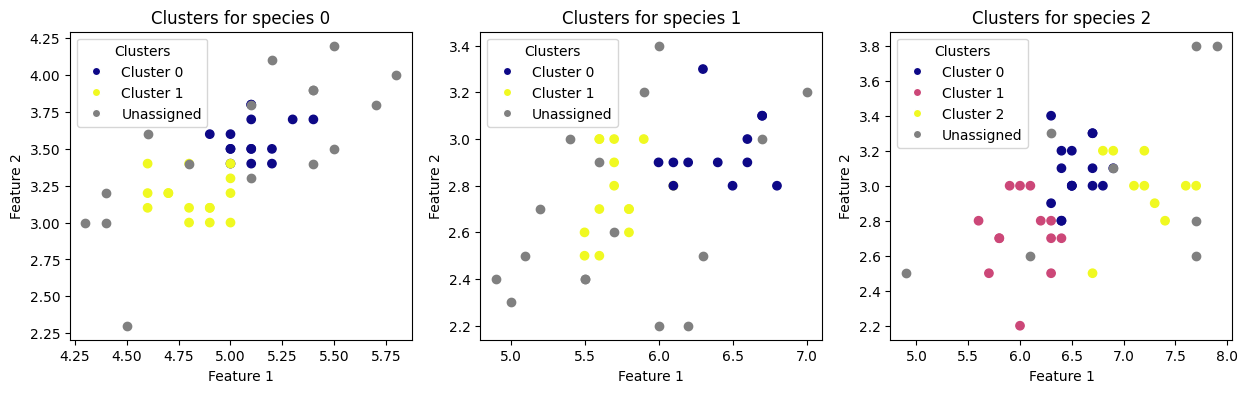

In [25]:
plot_clusters(G,w_min)

We can see, approximately, that the clusters are defined in a way that the distance within each cluster is minimum. However, as we cannot represent to 4-dimensional space to which the data belongs, it is difficult to observe in some cases.

# QUBO solution using D-Wave's Leap Hybrid Solver

In this section we are going to use the Quantum Annealing Sampler of D-Wave to solve the QUBO problem (and as it is real, it will be noisy). As we are using the free trial we only have 1 minute in total to compute and we cannot compute longer than $~0.6$ s each time we access to D-Wave servers. For this reason we can see that we do not observe any advantage with this method. In the case of small sized datasets we get the same results as with ```SimulatedAnnealingSampler```while for large sized ones, this method is worse.

Before doing that, you need to evaluate the time the computation will take because D-Wave credits are limited.

In [26]:
from dwave.system import DWaveSampler, EmbeddingComposite

qpu = DWaveSampler()
print(f"Time estimation for 100 qubits, 5000 samples: {qpu.solver.estimate_qpu_access_time(100, 3000)} µs on {qpu.solver.name}")

Time estimation for 100 qubits, 5000 samples: 594360.3502747507 µs on Advantage_system4.1


We solve the problem using Quantum Annealing.

In [27]:
# Then solve the problem on QPU
# Embedding Composite is doing the minor embedding for you

sampler = EmbeddingComposite(DWaveSampler())
q_sampleset=[0,0,0]


In [28]:
q_sampleset[0] = sampler.sample(bqm[0], num_reads=3000, label='SDK Examples - Scheduling. Subset 0')

In [29]:
q_sampleset[1] = sampler.sample(bqm[1], num_reads=3000, label='SDK Examples - Scheduling. Subset 1')

In [30]:
q_sampleset[2] = sampler.sample(bqm[2], num_reads=3000, label='SDK Examples - Scheduling. Subset 2')

We show the result.

In [31]:
for k in range(3):
    print(q_sampleset[k].lowest(atol=0.5))          

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 ... 91      energy num_oc. ...
0  0  1  0  0  1  1  0  0  0  0  1  0  1  0  1 ...  0 -178.320889       1 ...
['BINARY', 1 rows, 1 samples, 92 variables]
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 ... 83      energy num_oc. ...
0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  0 ...  1 -230.158049       1 ...
['BINARY', 1 rows, 1 samples, 84 variables]
   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 ... 140      energy num_oc. ...
0  1  1  1  0  0  0  0  0  1  1  0  0  0  0  0 ...   0 -679.261978       1 ...
['BINARY', 1 rows, 1 samples, 141 variables]


In [32]:
q_records=[0,0,0]
q_w_min=[0,0,0]

for k in range(3):
    q_records[k]=q_sampleset[k].lowest(atol=.5).record

    for i, q_record in enumerate(q_records[k]):
        sample = q_record['sample']
        energy = q_record['energy']
        print(f"-Solution for subset {k}: {sample}, Energy: {energy}, Check: {CheckClusters(sample,n[k],K[k])}" )
        print()

        q_w_min[k]=sample 

-Solution for subset 0: [0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0
 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0], Energy: -178.32088888888927, Check: (False, array([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 0]), 0.6521739130434783)

-Solution for subset 1: [0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0
 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0
 1 0 0 0 0 0 1 0 0 1], Energy: -230.1580487804873, Check: (False, array([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]), 0.6190476190476191)

-Solution for subset 2: [1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 

In [33]:
q_assignment=[0,0,0]
for k in range(3):
    q_assignment[k]=AssignCluster(q_w_min[k],n[k],K[k])
    print("Assignments for subset "+ str(k))
    print(q_assignment[k])

print()

for k in range(3):
    print("Assignments ratio for subset "+ str(k))
    print()
    for i in range(-2, len(q_assignment)):
        if i==-2:
            print('Multiply assigned:', np.sum(q_assignment[k]== i)/len(q_assignment[k]))
        elif i==-1:
            print('Unassigned:       ', np.sum(q_assignment[k]== i)/len(q_assignment[k]))
        else:
            print('Cluster '+str(i)+':        ', np.sum(q_assignment[k]== i)/len(q_assignment[k]))
    print()

Assignments for subset 0
[ 1  0  1  1  0  0 -1  1 -1 -1  0 -1  0  1  0  1  0 -1  0 -1 -1 -1  0  1
  0  0  1  0  1  0 -1  0  1  1 -1  1  1  0 -1  0 -1 -1 -1  1 -1 -1]
Assignments for subset 1
[ 1 -1 -1 -1 -1  1  1 -1  1  1  1  0  0  0 -1 -1  0  0  1  0 -1  1  0 -1
  0  1 -1  0  1 -1 -1 -1  1 -1  0  0 -1  0  1  0 -1  1]
Assignments for subset 2
[ 0  0  0  2  2  1 -1  1  0  0 -1 -1  1  1  2  0 -1  1  0  0  2  2  1  0
  0  1  0  1  0  1  0 -1  2  1  2  2  0  1 -1 -1  1  2 -1  1  2  1 -1]

Assignments ratio for subset 0

Multiply assigned: 0.0
Unassigned:        0.34782608695652173
Cluster 0:         0.34782608695652173
Cluster 1:         0.30434782608695654
Cluster 2:         0.0

Assignments ratio for subset 1

Multiply assigned: 0.0
Unassigned:        0.38095238095238093
Cluster 0:         0.30952380952380953
Cluster 1:         0.30952380952380953
Cluster 2:         0.0

Assignments ratio for subset 2

Multiply assigned: 0.0
Unassigned:        0.19148936170212766
Cluster 0:         0.297

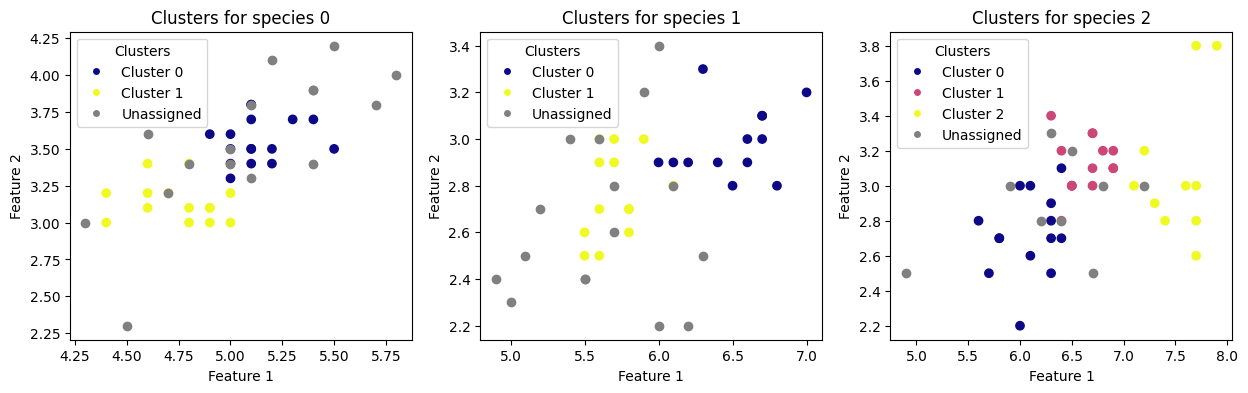

In [34]:
plot_clusters(G, q_w_min)

## References

[1] Lenny Putri Yulianti, Agung Trisetyarso, Judhi Santoso, Kridanto Surendro. _A hybrid quantum annealing method for generating ensemble classifiers._ Journal of King Saud University - Computer and Information Sciences 35 (2023), 101831.

[2] Arthur, D., Date, P., 2021. _Balanced k-means clustering on an adiabatic quantum computer._ Quantum Inf Process 20, 294. https://doi.org/10.1007/s11128-021-03240-8.
